@Author: Shofi

2022/11/10

### Task 1: Import Libraries

In [56]:
from random import random
import matplotlib.pyplot as plt
import os
#import PIL
import tensorflow as tf
import time
import scipy

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, GlobalAveragePooling2D#, Input,Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential#, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
#from sklearn.model_selection import KFold, StratifiedKFold

from IPython.display import clear_output
from matplotlib import get_backend

#from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.2


### Task 2: Plot Sample Images

In [57]:
print("Training data:")
for expression in os.listdir("daisee/train/"):
    if not expression.startswith('.'):  
        print(str(len(os.listdir("daisee/train/" + expression))) + " " + expression + " images")

print("\nValidation data:")
for expression in os.listdir("daisee/evaluation/"):
    if not expression.startswith('.'):  
        print(str(len(os.listdir("daisee/evaluation/" + expression))) + " " + expression + " images")

print("\nTest data:")
for expression in os.listdir("daisee/test/"):
    if not expression.startswith('.'):  
        print(str(len(os.listdir("daisee/test/" + expression))) + " " + expression + " images")

Training data:
2395 normallyEngaged images
2401 normally_engaged images
218 notEngaged images
215 not_engaged images
2432 veryEngaged images
2429 very_engaged images

Validation data:


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'daisee/evaluation/'

### Task 3: Generate Training and Validation Batches

In [ ]:
img_size = 96 #set image 
batch_size = 32 #can change to see if the it gives better result

#datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train = ImageDataGenerator(
                # rescale=1./255,
                # rotation_range=30,
                # shear_range=0.3,
                # zoom_range=0.3,
                horizontal_flip=True)
datagen_validation = ImageDataGenerator(horizontal_flip=False)

#load images from training directory
train_generator = datagen_train.flow_from_directory("daisee/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_train.flow_from_directory("daisee/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

test_generator = datagen_train.flow_from_directory("daisee/evaluation/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 5045 images belonging to 3 classes.
Found 1525 images belonging to 3 classes.
Found 1459 images belonging to 3 classes.


In [ ]:
from sklearn.utils import shuffle


train_dataset = tf.keras.utils.image_dataset_from_directory("daisee/train/",
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=(img_size,img_size))
validation_dataset = tf.keras.utils.image_dataset_from_directory("daisee/test/",
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=(img_size,img_size))
test_dataset = tf.keras.utils.image_dataset_from_directory("daisee/validation/",
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=(img_size,img_size))                                                       

Found 10090 files belonging to 6 classes.
Found 3010 files belonging to 6 classes.
Found 1459 files belonging to 3 classes.


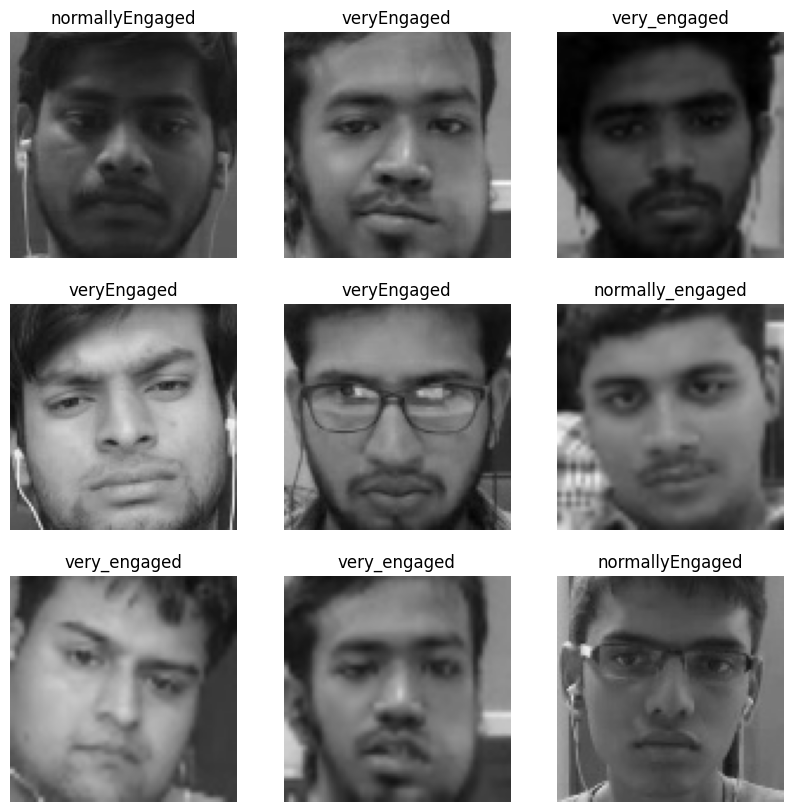

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
from matplotlib import test

# configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/o become blocking

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

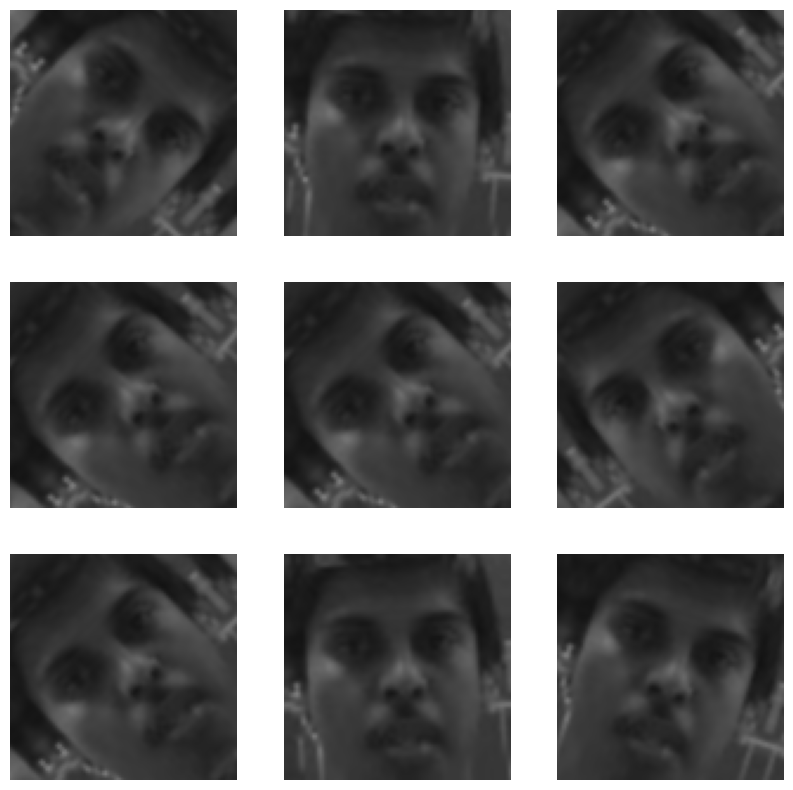

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127/5, offset=-1)

In [69]:
# create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_size,img_size) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

In [70]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


In [71]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_14[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

In [72]:
# Add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #convert the features to a single 1280-element vector per image
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [78]:
prediction_layer = tf.keras.layers.Dense(1) #convert features into a single prediction per image
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [79]:
# Build the model

inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv_14 (TFOpLam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 tf.math.subtract_14 (TFOpLa  (None, 96, 96, 3)        0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                          

In [80]:
len(model.trainable_variables) #weights and biases

2

In [81]:
# Train the model

initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

95/95 [==============================] - 2s 9ms/step - loss: 2.8107e-07 - accuracy: 0.2538
initial loss: 0.00
initial accuracy: 0.25


In [82]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
316/316 [==============================] - 10s 25ms/step - loss: 2.9956e-07 - accuracy: 0.2296 - val_loss: 2.8107e-07 - val_accuracy: 0.2538
Epoch 2/10
316/316 [==============================] - 8s 25ms/step - loss: 2.9956e-07 - accuracy: 0.2308 - val_loss: 2.8107e-07 - val_accuracy: 0.2538
Epoch 3/10
316/316 [==============================] - 8s 25ms/step - loss: 2.9956e-07 - accuracy: 0.2309 - val_loss: 2.8107e-07 - val_accuracy: 0.2538
Epoch 4/10
316/316 [==============================] - 8s 25ms/step - loss: 2.9956e-07 - accuracy: 0.2311 - val_loss: 2.8107e-07 - val_accuracy: 0.2538
Epoch 5/10
316/316 [==============================] - 8s 25ms/step - loss: 2.9956e-07 - accuracy: 0.2296 - val_loss: 2.8107e-07 - val_accuracy: 0.2538
Epoch 6/10
316/316 [==============================] - 8s 25ms/step - loss: 2.9956e-07 - accuracy: 0.2302 - val_loss: 2.8107e-07 - val_accuracy: 0.2538
Epoch 7/10
316/316 [==============================] - 8s 25ms/step - loss: 2.9956e-07 - accur

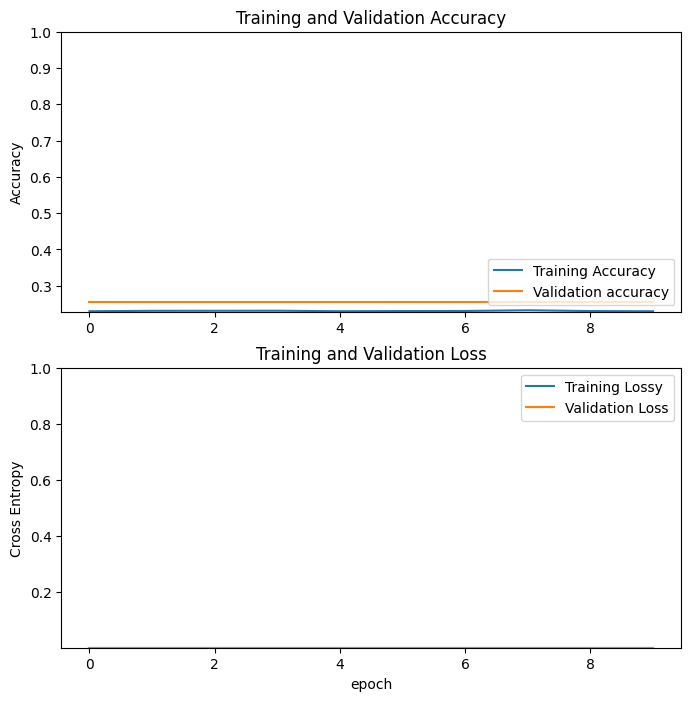

In [83]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Lossy')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [84]:
# Evaluation and predication

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)

46/46 [==============================] - 0s 8ms/step - loss: 9.6658e-08 - accuracy: 0.5408
Test accuracy: 0.5407813787460327


In [61]:
# Fine Tuning
base_model.trainable =True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100 #fine tune from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


Number of layers in the base model:  154


In [ ]:
# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

###  Task 4: Training and Evcaluation: 1. Murshed, 2. VGG, 3. Modif

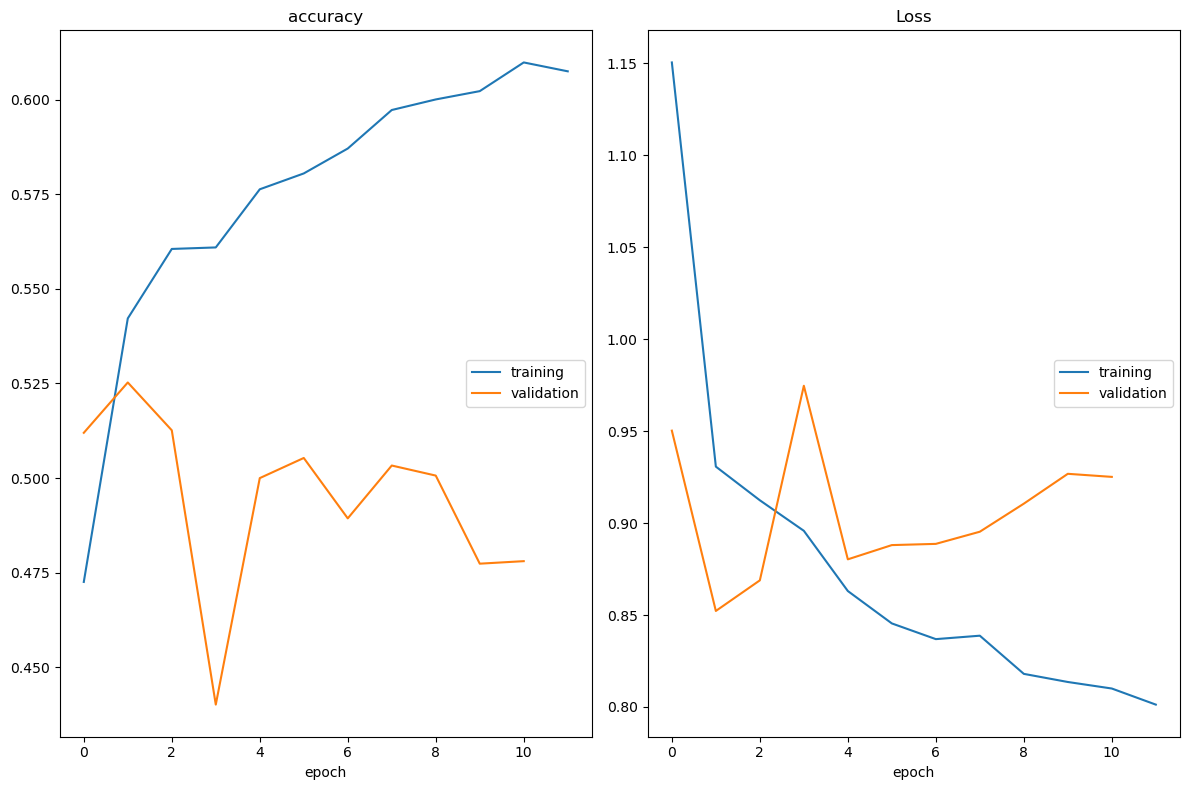

accuracy
	training         	 (min:    0.473, max:    0.610, cur:    0.607)
	validation       	 (min:    0.440, max:    0.525, cur:    0.478)
Loss
	training         	 (min:    0.801, max:    1.151, cur:    0.801)
	validation       	 (min:    0.852, max:    0.975, cur:    0.925)

Epoch 00012: saving model to weights/weights_murshed2019.h5
 83/157 [==============>...............] - ETA: 8s - loss: 0.8016 - accuracy: 0.6075

KeyboardInterrupt: 

In [52]:
## Mursheed
# Initialising the CNN
model = Sequential()

model.add(Conv2D(192,(3,3), padding='same', input_shape=(img_size, img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(192,(1,1)))
model.add(Activation('relu'))

model.add(Conv2D(192,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(96,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(96,(1,1)))
model.add(Conv2D(96,(1,1)))

model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model.add(Dropout(0.3))

model.add(Conv2D(32,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fully connected layer 2nd layer
model.add(Dense(512, name = 'convy'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

'''
model.add(Conv2D(3,(1,1), name = 'convy'))
model.add(GlobalAveragePooling2D())
'''
model.add(Dense(3, activation='softmax'))

model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001) #0.0001
opt = Adam(lr=0.0001)#0.0005
#opt = SGD(lr=0.01, decay=0, momentum=0.01)#decay=1e-6, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tic = time.time()

# ################ Train and Evaluate Model ###############################

epochs = 300
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/batch size
#n number of samples in train_generator // (floor division) by batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#make checkpoint and save it when it reach the best accuracy during the training
checkpoint = ModelCheckpoint("weights/weights_murshed2019.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)#make check point during training and save the weight

#learning rate schedule: reduce learning rate 0.1 every 2 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

#use livelossplot to monitor the accuracy during the training 
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr, early_stopping] 
# callbacks = [PlotLossesCallback(), checkpoint, reduce_lr] 

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# print duration
toc = time.time()

tictoc = 1000*(toc-tic)
tictocC = str(round(tictoc,3))

print("Training and Validation:" + tictocC+" ms")

plt.savefig('Accuracy_murshed2019.png')
 
  
# ### Represent Model as JSON String

model_json = model.to_json()
with open("model_murshed2019.json", "w") as json_file:
    json_file.write(model_json)

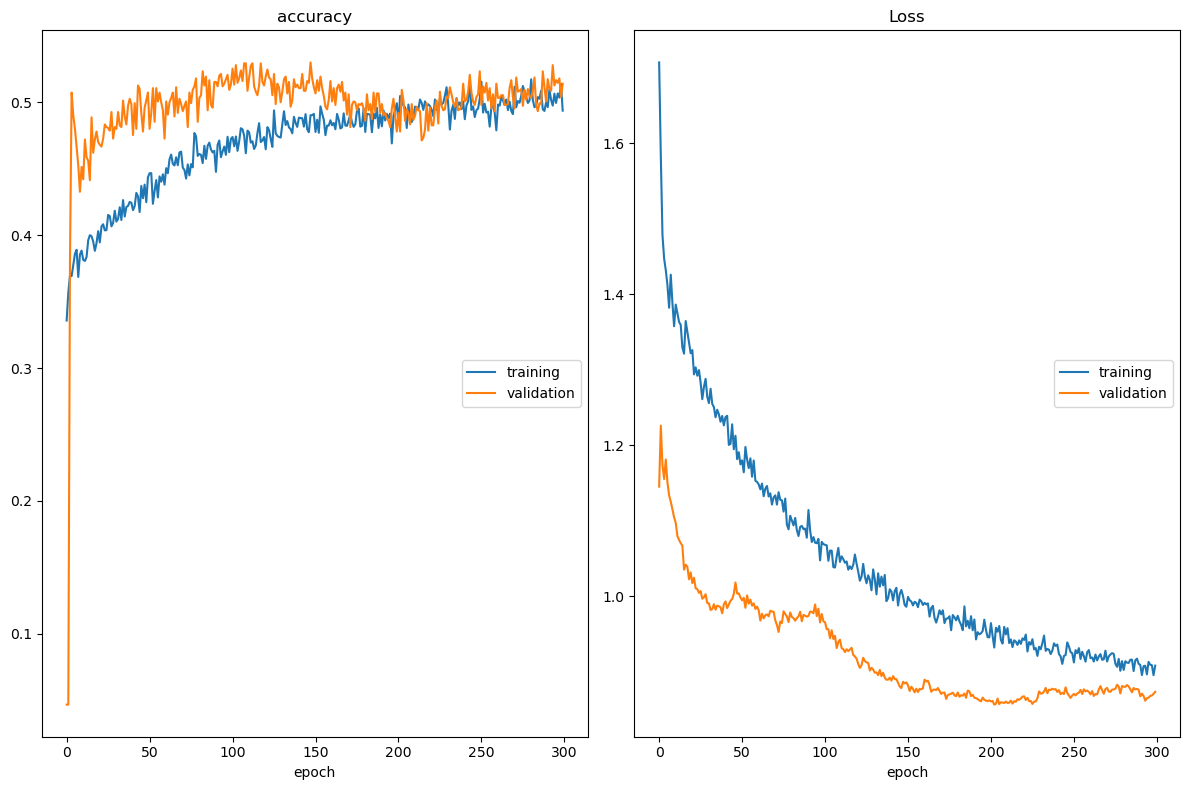

accuracy
	training         	 (min:    0.336, max:    0.517, cur:    0.494)
	validation       	 (min:    0.047, max:    0.530, cur:    0.514)
Loss
	training         	 (min:    0.896, max:    1.707, cur:    0.908)
	validation       	 (min:    0.857, max:    1.226, cur:    0.874)

Epoch 00300: saving model to weights/weights_4convBlocks.h5
100/100 [==============================] - 3s 29ms/step - loss: 0.9084 - accuracy: 0.4937 - val_loss: 0.8738 - val_accuracy: 0.5140
Training and Evaluation:868494.434 ms


In [5]:
## Modified

# Initialising the CNN
model = Sequential()

## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
# 1 - Convolution
model.add(Conv2D(32,(3,3), input_shape=(img_size, img_size,1))) #64,(3,3), padding='same', input_shape=(img_size, img_size,1)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #downsampling/ shrink the height and width dimension by factor of 2  
model.add(Dropout(0.2))#0.25

# 2nd Convolution layer
model.add(Conv2D(64,(3,3) ))#128,(5,5), padding='same')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolution layer
model.add(Conv2D(128,(3,3)))#(512,(3,3), padding='same')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 4th Convolution layer
model.add(Conv2D(256,(3,3)))#(512,(3,3), padding='same')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(64))#(256)
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

'''
# Fully connected layer 2st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
'''
# Fully connected layer 3nd layer
model.add(Dense(64, name = 'convy'))#512, name = 'convy')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
'''
model.add(Conv2D(3,(1,1), name = 'convy'))
model.add(GlobalAveragePooling2D())
'''
model.add(Dense(3, activation='softmax'))

model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001) #0.0001
opt = Adam(lr=0.0001)#0.0005
#opt=SGD(lr=0.005, momentum = 0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ### Visualize Model Architecture

plot_model(model, to_file='models/model_4convBlocks.png', show_shapes=True, show_layer_names=True)
#Image('model_serv.png',width=400, height=200)

tic = time.time()

# ### Train and Evaluate Model
epochs =300
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/batch size

validation_steps = validation_generator.n//validation_generator.batch_size #n number of samples in train_generator // (floor division) by batch_size

#make checkpoint and save it when it reach the best accuracy during the training
checkpoint = ModelCheckpoint("weights/weights_4convBlocks.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)#make check point during training and save the weight

#learning rate schedule: reduce learning rate 0.1 every 2 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#use livelossplot to monitor the accuracy during the training 

#callbacks = [PlotLossesCallback(), checkpoint, reduce_lr, early_stopping] 
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr] 

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# print duration
toc = time.time()

tictoc = 1000*(toc-tic)
tictocC = str(round(tictoc,3))

print("Training and Evaluation:" + tictocC+" ms")

plt.savefig('models/Accuracy_4convBlocks.png')
 
  
# ### Represent Model as JSON String

model_json = model.to_json()
with open("models/model_4convBlocks.json", "w") as json_file:
    json_file.write(model_json)


In [18]:
### VGG
import keras.applications.vgg16 import VGG16
import keras.models import Model 
from keras.layers import Dense
from keras.layers import Flatten

SyntaxError: invalid syntax (<ipython-input-18-7a4caf4bf902>, line 2)

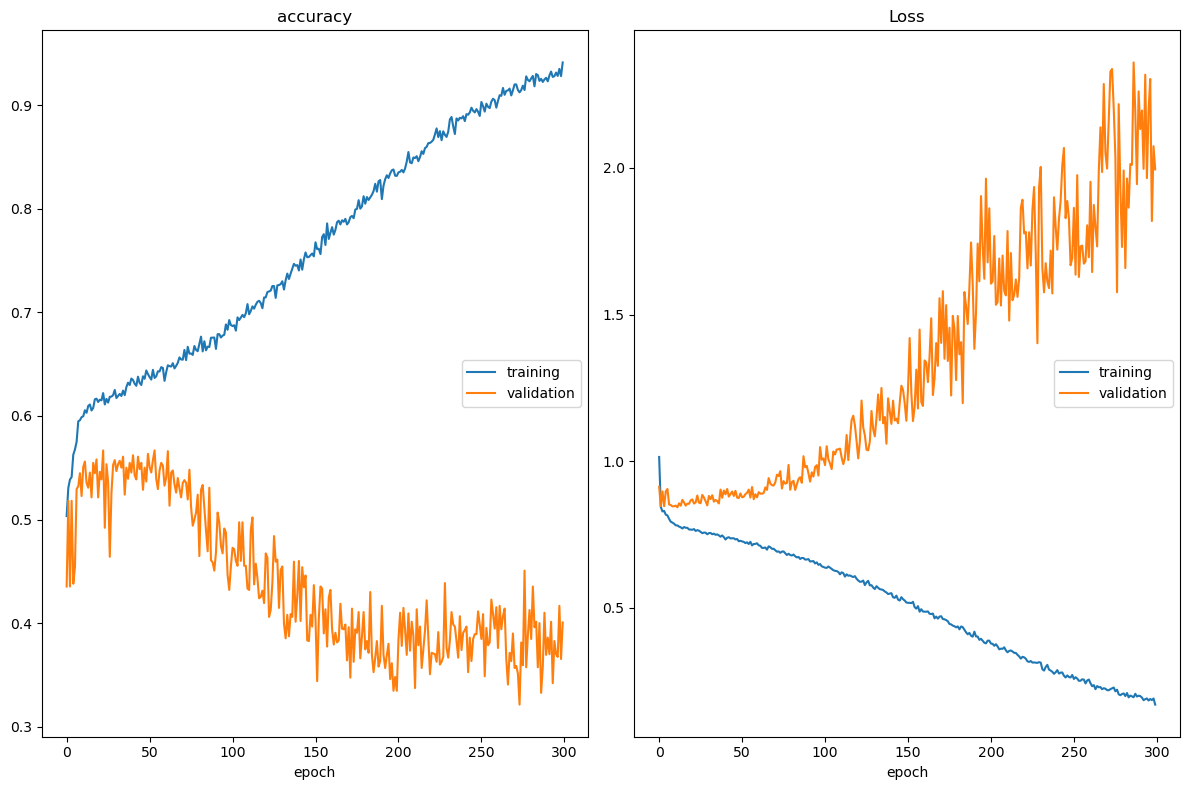

accuracy
	training         	 (min:    0.503, max:    0.941, cur:    0.941)
	validation       	 (min:    0.321, max:    0.567, cur:    0.401)
Loss
	training         	 (min:    0.169, max:    1.014, cur:    0.169)
	validation       	 (min:    0.842, max:    2.360, cur:    1.995)

Epoch 00300: saving model to weights/weights_vggB.h5
100/100 [==============================] - 3s 34ms/step - loss: 0.1687 - accuracy: 0.9411 - val_loss: 1.9952 - val_accuracy: 0.4007
Training and Evaluation:994237.066 ms


In [6]:
## VGG

# Initialising the CNN
model = Sequential()

## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(img_size, img_size,1)))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #downsampling/ shrink the height and width dimension by factor of 2  
#model.add(Dropout(0.5))

# 2nd Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

# 5th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(4096))#256
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(4096))#4096
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(1000, name = 'convy'))#512
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))
'''
model.add(Conv2D(3,(1,1), name = 'convy'))
model.add(GlobalAveragePooling2D())
'''

model.add(Dense(3, activation='softmax'))

model.get_layer('convy').kernel_regularizer = regularizers.l1(0.0001) #0.0001
opt = Adam(lr=0.0001)
#opt=SGD(lr=0.02, momentum = 0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ### Visualize Model Architecture

plot_model(model, to_file='models/new-model_vggB.png', show_shapes=True, show_layer_names=True)
#Image('model_serv.png',width=400, height=200)

tic = time.time()

##################### Training and Evaluation ###############################

epochs = 300
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/batch size
#n number of samples in train_generator // (floor division) by batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#make checkpoint and save it when it reach the best accuracy during the training
checkpoint = ModelCheckpoint("weights/weights_vggB.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)#make check point during training and save the weight

#learning rate schedule: reduce learning rate 0.1 every 2 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#use livelossplot to monitor the accuracy during the training 
#callbacks = [PlotLossesCallback(), checkpoint, reduce_lr, early_stopping]
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr] 

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# print duration
toc = time.time()

tictoc = 1000*(toc-tic)
tictocC = str(round(tictoc,3))

print("Training and Evaluation:" + tictocC+" ms")

plt.savefig('models/Accuracy_vggB.png')

## Export Models
model_json = model.to_json()
with open("models/new-modelsmodel_vggB.json", "w") as json_file:
    json_file.write(model_json)

model_json = model.to_json()
with open("modelsmodel_vggB.json", "w") as json_file:
    json_file.write(model_json)

### Export The Model